## 0. Setup & Imports

Load Python libraries for data prep, visualization, and GLM modeling.


In [1184]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data & Preview

Read the auto insurance dataset and inspect the first rows to confirm field names and target variables.

In [1186]:
df = pd.read_csv('car_insurance_claim.csv')
df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


## 2. Data Audit (Schema + Missingness)

Check datatypes and missing values to plan cleaning and modeling.
Key missing fields include YOJ, INCOME, HOME_VAL, OCCUPATION, CAR_AGE.

In [1190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [1191]:
df.isnull().sum()

ID              0
KIDSDRIV        0
BIRTH           0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
dtype: int64

## 3. Target Distributions (Frequency & Paid Loss)

Inspect:
- CLM_FREQ distribution (many zeros, low counts)
- CLM_AMT is currently a string and includes "$0" values (paid-loss target with mass at zero)


In [1193]:
df['CLM_FREQ'].value_counts()

CLM_FREQ
0    6292
2    1492
1    1279
3     992
4     225
5      22
Name: count, dtype: int64

In [1194]:
df['CLM_FREQ'].describe()

count    10302.000000
mean         0.800718
std          1.154079
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          5.000000
Name: CLM_FREQ, dtype: float64

In [1195]:
df['CLM_AMT'].value_counts()

CLM_AMT
$0         7556
$2,327        4
$3,674        4
$3,350        4
$4,363        4
           ... 
$5,837        1
$9,663        1
$856          1
$24,494       1
$1,815        1
Name: count, Length: 2346, dtype: int64

In [1196]:
df['CLM_AMT'].describe()

count     10302
unique     2346
top          $0
freq       7556
Name: CLM_AMT, dtype: object

## 4. Data Cleaning (Currency → Numeric + Binary Mapping)

Convert currency-like fields (CLM_AMT, INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM) to numeric.
Map binary categorical fields (RED_CAR, REVOKED, PARENT1, MSTATUS) to 0/1.


In [1198]:
df['CLM_AMT'] = df['CLM_AMT'].replace(r'[\$,]', '', regex=True).astype(float)

In [1199]:
df['CLM_AMT'].describe()

count     10302.000000
mean       1511.266453
std        4725.249896
min           0.000000
25%           0.000000
50%           0.000000
75%        1144.750000
max      123247.000000
Name: CLM_AMT, dtype: float64

In [1200]:
df['INCOME'] = df['INCOME'].replace(r'[\$,]', '', regex = True).astype(float)
df['HOME_VAL'] = df['HOME_VAL'].replace(r'[\$,]','', regex = True).astype(float)
df['BLUEBOOK'] = df['BLUEBOOK'].replace(r'[\$,]', '', regex = True).astype(float)
df['OLDCLAIM'] = df['OLDCLAIM'].replace(r'[\$,]', '', regex = True).astype(float)

In [1201]:
df['RED_CAR'] = df['RED_CAR'].map({'yes': 1, 'no': 0})
df['REVOKED'] = df['REVOKED'].map({'Yes': 1, 'No': 0})
df['PARENT1'] = df['PARENT1'].map({'Yes': 1, 'No': 0})
df['MSTATUS'] = df['MSTATUS'].map({'Yes': 1, 'z_No': 0})

## 5. Preserve Segment Labels + One-Hot Encode Categoricals

Save raw segment labels (Urbanicity, Car Type, MVR points) for later **relativity tables**.
Then one-hot encode categorical predictors for GLM modeling.

In [1203]:
# CODE 13 — Save raw labels + encode categoricals
seg_labels = df[["URBANICITY", "CAR_TYPE", "MVR_PTS"]].copy()

categorical_cols = ["CAR_TYPE", "URBANICITY", "OCCUPATION", "EDUCATION", "CAR_USE", "GENDER"]
cols_to_encode = [c for c in categorical_cols if c in df.columns]

if len(cols_to_encode) == 0:
    print("No categorical columns found to encode (already encoded). Skipping get_dummies().")
else:
    df[cols_to_encode] = df[cols_to_encode].astype("string")
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)


## 6. Modeling Frames & Pricing Target Definition

Define:
- PAID_CLAIM = 1{CLM_AMT > 0} for occurrence modeling
- df_freq: all policies (used for occurrence & scoring)
- df_sev: paid-claim policies (used for severity)


In [1205]:
df_freq = df.copy()

In [1207]:
df["PAID_CLAIM"] = (df["CLM_AMT"] > 0).astype(int)
df_freq = df.copy()

In [1209]:
df_sev = df[df['CLM_AMT'] > 0].copy()

## 7. Feature Matrix Construction (Prevent Leakage)

Build X/y for:
- Frequency (CLM_FREQ) – exploratory claim count model
- Severity (CLM_AMT | CLM_AMT > 0)

Explicitly drop leakage columns (CLM_AMT, CLAIM_FLAG, PAID_CLAIM, ID, BIRTH).


In [1211]:
# This is our Frequnecy Target, hence what we will be predicting 
y_freq = df_freq['CLM_FREQ']

X_freq = df_freq.drop(columns=[
    'CLM_FREQ',
    'CLM_AMT',
    'CLAIM_FLAG',
    'PAID_CLAIM',   # <-- ADD THIS
    'ID',
    'BIRTH',
])




In [1213]:
# This is our severity target, hence what we will be predicting 
y_sev = df_sev['CLM_AMT']

X_sev = df_sev.drop(columns=[
    'CLM_AMT',
    'CLM_FREQ',
    'CLAIM_FLAG',
    'PAID_CLAIM',   # <-- ADD THIS
    'ID',
    'BIRTH',
])


## 8. Frequency Diagnostics (Overdispersion & Zero Mass)

Compute mean/variance and compare observed vs expected zero rate under Poisson.
This motivates using Negative Binomial over Poisson for claim counts.

In [1215]:
# Here we do a basic distribtion check for frequency target 
mean_freq =  y_freq.mean()
var_freq = y_freq.var()
zero_rate = (y_freq == 0).mean()

print("MEAN(CLM_FREQ):", mean_freq)
print("Var(CLM_FREQ):", var_freq)
print("Var/Mean", var_freq / mean_freq if mean_freq > 0 else None )

print("\nValue counts (top):")
print(y_freq.value_counts().sort_index())

MEAN(CLM_FREQ): 0.8007183071248302
Var(CLM_FREQ): 1.3318973579775617
Var/Mean 1.66337817697719

Value counts (top):
CLM_FREQ
0    6292
1    1279
2    1492
3     992
4     225
5      22
Name: count, dtype: int64


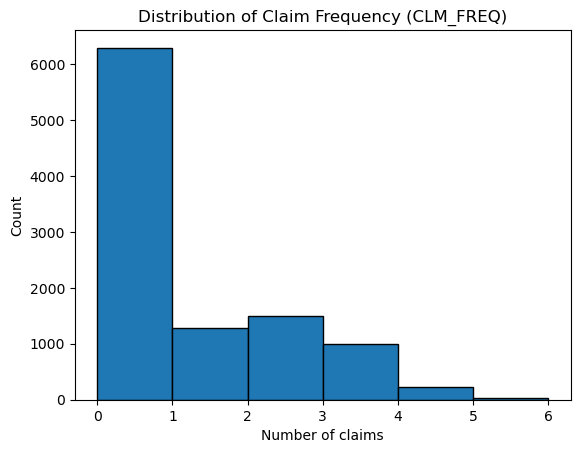

In [1217]:
## Visual of whats above
import  matplotlib.pyplot as plt

plt.hist(y_freq, bins=range(int(y_freq.max()) + 2), edgecolor = 'black')
plt.title("Distribution of Claim Frequency (CLM_FREQ)")
plt.xlabel("Number of claims")
plt.ylabel('Count')
plt.show()

In [1219]:
# observed proportion of zero-claim policies
observed_zero_rate = (y_freq == 0).mean() 

# Expected  zero rate under possion with same mean
import numpy as np
expected_zero_rate_possion = np.exp(-mean_freq)

print("Observed zero rate:", observed_zero_rate)
print("Expected Zero rate: ", expected_zero_rate_possion)
print("Observed/ Expected: ", observed_zero_rate / expected_zero_rate_possion )

Observed zero rate: 0.6107551931663755
Expected Zero rate:  0.44900632381219113
Observed/ Expected:  1.3602373970613388


## 9. Train vs Score Design Matrices (Complete-Case Fit + Imputed Scoring)

Fit models on complete-case rows (dropna) for stable estimation.
Score ALL policies using median imputation so every policy receives predictions.

In [1221]:
import numpy as np
import statsmodels.api as sm

# -------------------------
# A) FIT DATA (dropna is fine)
# -------------------------
data_freq = pd.concat([y_freq, X_freq], axis=1).dropna()
y_freq_fit = data_freq["CLM_FREQ"].astype(float)
X_freq_fit = data_freq.drop(columns=["CLM_FREQ"])
X_freq_fit_const = sm.add_constant(X_freq_fit, has_constant="add").astype(float)

# -------------------------
# B) SCORE DATA (ALL policies)
#   - DO NOT drop rows
#   - impute missing numerics
# -------------------------
X_freq_score = X_freq.copy()

num_cols = X_freq_score.select_dtypes(include=[np.number]).columns
X_freq_score[num_cols] = X_freq_score[num_cols].fillna(X_freq_score[num_cols].median())

# any remaining NaNs (e.g., weird non-numeric) → 0
X_freq_score = X_freq_score.fillna(0)

X_freq_score_const = sm.add_constant(X_freq_score, has_constant="add").astype(float)


## 10. Exploratory Claim Count Model (Poisson vs Negative Binomial)

Fit Poisson and Negative Binomial GLMs to CLM_FREQ.
Use NB to handle overdispersion; interpret effects as multiplicative changes (exp(coef)).

In [1223]:
poisson_model = sm.GLM(y_freq_fit, X_freq_fit_const, family=sm.families.Poisson()).fit()
nb_model = sm.GLM(y_freq_fit, X_freq_fit_const, family=sm.families.NegativeBinomial()).fit()

C:\Users\caman\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [1225]:
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               CLM_FREQ   No. Observations:                 8163
Model:                            GLM   Df Residuals:                     8127
Model Family:        NegativeBinomial   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8659.2
Date:                Mon, 05 Jan 2026   Deviance:                       5479.1
Time:                        16:25:00   Pearson chi2:                 6.92e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.2995
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

## 11. Occurrence Model (Paid Claim Probability)

Fit a Binomial (logit) GLM for PAID_CLAIM using the same predictor set.
This aligns the pricing framework with paid-loss severity (conditional on CLM_AMT > 0).

In [1227]:
# Occurrence model (paid claim indicator)
y_occ = df_freq["PAID_CLAIM"]
# Make sure target is NOT in predictors
X_occ = X_freq.drop(columns=["PAID_CLAIM"], errors="ignore").copy()

y_occ = df_freq["PAID_CLAIM"].astype(int)

data_occ = pd.concat([y_occ, X_occ], axis=1).dropna()
y_occ_fit = data_occ["PAID_CLAIM"].astype(float)
X_occ_fit = data_occ.drop(columns=["PAID_CLAIM"])

X_occ_fit_const = sm.add_constant(X_occ_fit, has_constant="add").astype(float)

occ_model = sm.GLM(y_occ_fit, X_occ_fit_const, family=sm.families.Binomial()).fit()
print(occ_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             PAID_CLAIM   No. Observations:                 8163
Model:                            GLM   Df Residuals:                     8127
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3674.1
Date:                Mon, 05 Jan 2026   Deviance:                       7348.1
Time:                        16:25:00   Pearson chi2:                 8.77e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2310
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

## 12. Severity Model (Gamma GLM on Paid Claims)

Explore the paid-loss distribution (heavy right tail).
Fit Gamma GLM with log link on df_sev (CLM_AMT > 0) to estimate expected paid severity.

Mean: 5669.725782957028
Variance: 60203008.30984128
Variance / Mean: 10618.328048740761


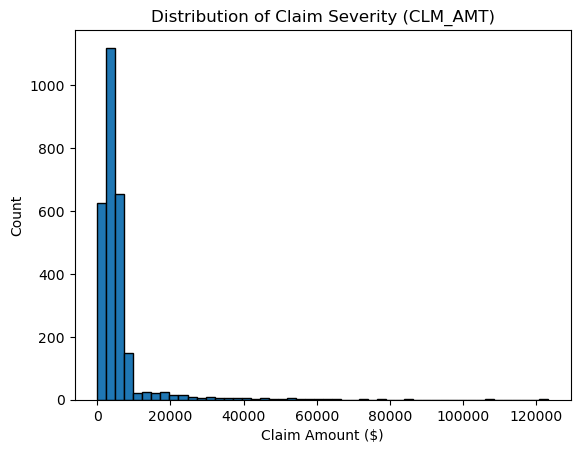

In [1229]:
# Severity target
y_sev = df_sev['CLM_AMT']

# Basic stats
print("Mean:", y_sev.mean())
print("Variance:", y_sev.var())
print("Variance / Mean:", y_sev.var() / y_sev.mean())

# Distribution shape
import matplotlib.pyplot as plt

plt.hist(y_sev, bins=50, edgecolor='black')
plt.title("Distribution of Claim Severity (CLM_AMT)")
plt.xlabel("Claim Amount ($)")
plt.ylabel("Count")
plt.show()


In [1231]:
import statsmodels.api as sm

# 1) Target
y_sev = df_sev['CLM_AMT']

X_sev = df_sev.drop(columns=[
    'CLM_AMT',
    'CLM_FREQ',
    'CLAIM_FLAG',
    'PAID_CLAIM',   # <-- ADD THIS
    'ID',
    'BIRTH'
])


# 3) Align + drop missing
data_sev = pd.concat([y_sev, X_sev], axis=1).dropna()
y_sev_clean = data_sev['CLM_AMT']
X_sev_clean = data_sev.drop(columns=['CLM_AMT'])

# 4) Add intercept + enforce numeric
X_sev_const = sm.add_constant(X_sev_clean, has_constant='add')
X_sev_const = X_sev_const.astype(float)
y_sev_clean = y_sev_clean.astype(float)

# 5) Fit Gamma GLM with log link
gamma_model = sm.GLM(
    y_sev_clean,
    X_sev_const,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

# 6) View results
print(gamma_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                CLM_AMT   No. Observations:                 2189
Model:                            GLM   Df Residuals:                     2153
Model Family:                   Gamma   Df Model:                           35
Link Function:                    log   Scale:                          1.3038
Method:                          IRLS   Log-Likelihood:                -21182.
Date:                Mon, 05 Jan 2026   Deviance:                       1431.4
Time:                        16:25:01   Pearson chi2:                 2.81e+03
No. Iterations:                    21   Pseudo R-squ. (CS):            0.04302
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

C:\Users\caman\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## 13. Model Interpretation (Relativity-Style Effects)

Convert coefficients to multiplicative effects via exp(coef) for interpretability.
(Used as a quick “directional reasonableness” check, not a final rating plan.)

In [1233]:
import numpy as np

freq_params = nb_model.params
freq_effects = np.exp(freq_params)

freq_effects.sort_values()

URBANICITY_z_Highly Rural/ Rural    0.277753
REVOKED                             0.281339
const                               0.566822
CAR_USE_Private                     0.793072
OCCUPATION_Manager                  0.853849
EDUCATION_Masters                   0.877140
GENDER_z_F                          0.884888
OCCUPATION_z_Blue Collar            0.892540
MSTATUS                             0.923898
OCCUPATION_Home Maker               0.936448
OCCUPATION_Student                  0.948462
OCCUPATION_Professional             0.961010
EDUCATION_z_High School             0.962130
EDUCATION_Bachelors                 0.972223
EDUCATION_PhD                       0.981010
TIF                                 0.994858
RED_CAR                             0.995003
YOJ                                 0.996014
CAR_AGE                             0.999035
BLUEBOOK                            0.999992
HOME_VAL                            0.999999
INCOME                              0.999999
OLDCLAIM  

In [1235]:
sev_params = gamma_model.params
sev_effects = np.exp(sev_params)

sev_effects.sort_values()

OCCUPATION_Doctor                      0.658076
GENDER_z_F                             0.802036
MSTATUS                                0.848199
REVOKED                                0.884974
OCCUPATION_Manager                     0.895509
CAR_TYPE_Panel Truck                   0.914675
EDUCATION_z_High School                0.918827
CAR_TYPE_Van                           0.938678
CAR_USE_Private                        0.960642
PARENT1                                0.969456
CAR_AGE                                0.985165
KIDSDRIV                               0.986941
TIF                                    0.997960
AGE                                    0.998898
INCOME                                 0.999999
HOME_VAL                               1.000000
OLDCLAIM                               1.000003
BLUEBOOK                               1.000024
OCCUPATION_Student                     1.000197
TRAVTIME                               1.000227
MVR_PTS                                1

## 14. Pure Premium Scoring (Occurrence × Severity)

Score all policies:
- p_paid = P(PAID_CLAIM=1 | X)
- pred_sev = E(CLM_AMT | PAID_CLAIM=1, X)
- pure_premium_pred = p_paid × pred_sev

Then validate portfolio calibration (mean predicted vs mean actual CLM_AMT).

In [1237]:
# Build occurrence score matrix from imputed X_freq_score
X_occ_score = sm.add_constant(
    X_freq_score.reindex(columns=X_occ_fit.columns, fill_value=0),
    has_constant="add"
).astype(float)


df_freq["p_paid"] = occ_model.predict(X_occ_score)

# Severity scoring matrix must match severity fit columns exactly
X_all_sev = X_freq_score_const.reindex(columns=X_sev_const.columns, fill_value=0)
df_freq["pred_sev"] = gamma_model.predict(X_all_sev)


df_freq["pure_premium_pred"] = df_freq["p_paid"] * df_freq["pred_sev"]


In [1239]:
print("Actual mean paid-claim rate:", df_freq["PAID_CLAIM"].mean())
print("Pred mean paid-claim prob:", df_freq["p_paid"].mean())
print("Actual mean CLM_AMT:", df_freq["CLM_AMT"].mean())
print("Pred mean pure premium:", df_freq["pure_premium_pred"].mean())
print("Ratio:", df_freq["pure_premium_pred"].mean() / df_freq["CLM_AMT"].mean())


Actual mean paid-claim rate: 0.2665501844302077
Pred mean paid-claim prob: 0.2666335160764274
Actual mean CLM_AMT: 1511.2664531158998
Pred mean pure premium: 1479.8353110604698
Ratio: 0.979202117541466


## 15. Validation: Decile Lift (Risk Ranking)

Rank policies by predicted pure premium and compute a decile lift table.
Report headline lift metrics (top decile loss share, decile 10 vs 1 ratio).

In [1241]:
import pandas as pd
import numpy as np

d = df_freq[["pure_premium_pred", "CLM_AMT"]].dropna().copy()

# 10 deciles by predicted pure premium (10 = highest risk)
d["decile"] = pd.qcut(d["pure_premium_pred"], 10, labels=False, duplicates="drop") + 1



lift = (
    d.groupby("decile", as_index=False)
     .agg(
         policies=("CLM_AMT", "size"),
         actual_loss=("CLM_AMT", "sum"),
         predicted_loss=("pure_premium_pred", "sum"),
         actual_mean=("CLM_AMT", "mean"),
         predicted_mean=("pure_premium_pred", "mean"),
     )
     .sort_values("decile")
)

total_actual = lift["actual_loss"].sum()
lift["actual_share"] = lift["actual_loss"] / total_actual
lift["cum_actual_share"] = lift["actual_share"].cumsum()
lift["pred_to_actual"] = lift["predicted_loss"] / lift["actual_loss"]

lift_display = lift.copy()
lift_display["actual_share"] = (lift_display["actual_share"] * 100).round(1)
lift_display["cum_actual_share"] = (lift_display["cum_actual_share"] * 100).round(1)
lift_display["pred_to_actual"] = lift_display["pred_to_actual"].round(3)
lift_display[["actual_mean", "predicted_mean", "actual_loss", "predicted_loss"]] = (
    lift_display[["actual_mean", "predicted_mean", "actual_loss", "predicted_loss"]].round(2)
)

lift_display

,decile,policies,actual_loss,predicted_loss,actual_mean,predicted_mean,actual_share,cum_actual_share,pred_to_actual
0,1,1031,128591.0,105475.66,124.72,102.30,0.8,0.8,0.820
1,2,1030,355176.0,243347.48,344.83,236.26,2.3,3.1,0.685
2,3,1030,402637.0,416684.98,390.91,404.55,2.6,5.7,1.035
3,4,1030,621958.0,655197.06,603.84,636.11,4.0,9.7,1.053
4,5,1030,940683.0,961914.99,913.28,933.90,6.0,15.7,1.023
5,6,1030,1436754.0,1331155.02,1394.91,1292.38,9.2,25.0,0.927
6,7,1030,1719100.0,1761664.13,1669.03,1710.35,11.0,36.0,1.025
7,8,1030,2274309.0,2298311.95,2208.07,2231.37,14.6,50.6,1.011
8,9,1030,3017600.0,3025189.13,2929.71,2937.08,19.4,70.0,1.003
9,10,1031,4672259.0,4446323.00,4531.77,4312.63,30.0,100.0,0.952


In [1243]:
top = lift.sort_values("decile").iloc[-1]   # decile 10
bottom = lift.sort_values("decile").iloc[0] # decile 1

top_loss_share = top["actual_loss"] / lift["actual_loss"].sum()
separation = top["actual_mean"] / bottom["actual_mean"]

print(f"Top decile captures {top_loss_share:.1%} of total losses.")
print(f"Decile 10 vs Decile 1 actual mean pure premium ratio: {separation:.2f}x")


Top decile captures 30.0% of total losses.
Decile 10 vs Decile 1 actual mean pure premium ratio: 36.33x


## 16. Actuarial Output: Segment Relativities (Observed vs Indicated)

Create segment-level tables comparing:
- actual_mean loss vs predicted_mean loss
- implied relativities by Urbanicity, Car Type, MVR bands

This turns the model into pricing-ready insights instead of “just GLMs.”

In [1245]:
# --- CODE 35.7 (Relativities using saved raw labels) ---

seg = seg_labels.loc[df_freq.index].copy()
seg["CLM_AMT"] = df_freq["CLM_AMT"].values
seg["pure_premium_pred"] = df_freq["pure_premium_pred"].values

seg["MVR_BAND"] = pd.cut(seg["MVR_PTS"], bins=[-1, 0, 2, 4, 99], labels=["0", "1-2", "3-4", "5+"])

def relativity_table(seg_df, col):
    t = (
        seg_df.groupby(col, as_index=False)
              .agg(
                  policies=("CLM_AMT", "size"),
                  actual_mean=("CLM_AMT", "mean"),
                  pred_mean=("pure_premium_pred", "mean"),
              )
    )
    # base = most common level
    base_level = seg_df[col].value_counts().idxmax()
    base_pred = t.loc[t[col] == base_level, "pred_mean"].iloc[0]
    base_act  = t.loc[t[col] == base_level, "actual_mean"].iloc[0]

    t["base_level"] = base_level
    t["pred_relativity"] = t["pred_mean"] / base_pred
    t["actual_relativity"] = t["actual_mean"] / base_act
    return t.round(3).sort_values("pred_relativity")

rel_urban = relativity_table(seg, "URBANICITY")
rel_cartype = relativity_table(seg, "CAR_TYPE")
rel_mvr = relativity_table(seg, "MVR_BAND")

rel_urban, rel_cartype, rel_mvr
 

C:\Users\caman\AppData\Local\Temp\ipykernel_41980\2264083077.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_df.groupby(col, as_index=False)


(              URBANICITY  policies  actual_mean  pred_mean  \
 1  z_Highly Rural/ Rural      2072      366.816    361.401   
 0    Highly Urban/ Urban      8230     1799.396   1761.414   
 
             base_level  pred_relativity  actual_relativity  
 1  Highly Urban/ Urban            0.205              0.204  
 0  Highly Urban/ Urban            1.000              1.000  ,
       CAR_TYPE  policies  actual_mean  pred_mean base_level  pred_relativity  \
 0      Minivan      2694      937.964    874.153      z_SUV            0.537   
 2       Pickup      1772     1750.356   1612.332      z_SUV            0.990   
 5        z_SUV      2883     1574.093   1629.316      z_SUV            1.000   
 4          Van       921     1804.663   1659.514      z_SUV            1.019   
 3   Sports Car      1179     1790.135   1783.358      z_SUV            1.095   
 1  Panel Truck       853     1910.654   1998.751      z_SUV            1.227   
 
    actual_relativity  
 0              0.596  
 2   

## 17. Diagnostic Plots (Reasonableness Checks)

Plot:
- actual vs predicted paid-claim probability (occurrence)
- actual vs predicted severity for paid claims

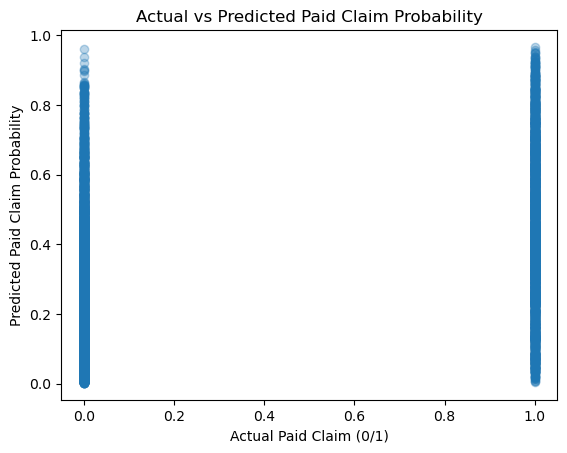

In [1247]:
import matplotlib.pyplot as plt

plt.scatter(df_freq["PAID_CLAIM"], df_freq["p_paid"], alpha=0.3)
plt.xlabel("Actual Paid Claim (0/1)")
plt.ylabel("Predicted Paid Claim Probability")
plt.title("Actual vs Predicted Paid Claim Probability")
plt.show()


## 18. Error Metrics (Context Only)

Compute RMSE/MAE for frequency, severity, and pure premium.
Note: individual-policy error is expected to be high due to heavy-tailed losses; lift and calibration are the primary pricing validations.

In [1249]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

freq_pred_fit = nb_model.predict(X_freq_fit_const)
rmse_freq = np.sqrt(mean_squared_error(y_freq_fit, freq_pred_fit))
mae_freq  = mean_absolute_error(y_freq_fit, freq_pred_fit)

print("Frequency RMSE (fit):", rmse_freq)
print("Frequency MAE (fit):", mae_freq)
print("Mean actual frequency (fit):", y_freq_fit.mean())
print("Mean predicted frequency (fit):", freq_pred_fit.mean())

Frequency RMSE (fit): 2.93070759176793
Frequency MAE (fit): 0.9742687770898663
Mean actual frequency (fit): 0.8027685899791743
Mean predicted frequency (fit): 1.080743712507228


##  Diagnostic Plots (Reasonableness Checks)

Plot:
- actual vs predicted paid-claim probability (occurrence)
- actual vs predicted severity for paid claims


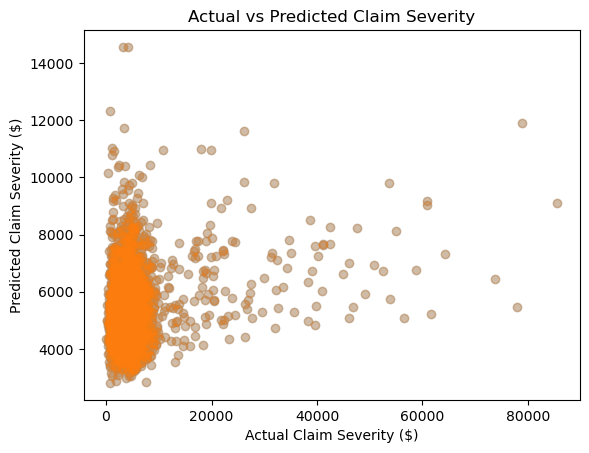

In [1251]:
df_sev["pred_sev"] = gamma_model.predict(X_sev_const)
plt.scatter(df_sev["CLM_AMT"], df_sev["pred_sev"], alpha=0.3)

plt.xlabel("Actual Claim Severity ($)")
plt.ylabel("Predicted Claim Severity ($)")
plt.title("Actual vs Predicted Claim Severity")
plt.show()


## Error Metrics (Context Only)

Compute RMSE/MAE for frequency, severity, and pure premium.
Note: individual-policy error is expected to be high due to heavy-tailed losses; lift and calibration are the primary pricing validations.


In [1253]:
sev_pred = gamma_model.predict(X_sev_const)
# Ensure y and predictions are aligned
y_sev_eval = y_sev.loc[X_sev_const.index]
sev_pred_eval = sev_pred


In [1255]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_sev = np.sqrt(mean_squared_error(y_sev_eval, sev_pred_eval))
mae_sev = mean_absolute_error(y_sev_eval, sev_pred_eval)

print("Severity RMSE:", rmse_sev)
print("Severity MAE:", mae_sev)
print("Mean actual severity:", y_sev_eval.mean())
print("Mean predicted severity:", sev_pred_eval.mean())


Severity RMSE: 7169.800325556519
Severity MAE: 3477.1654106214837
Mean actual severity: 5572.683417085427
Mean predicted severity: 5558.009002848461


In [1257]:
df_freq['pure_premium_actual'] = df_freq['CLM_AMT']  # already 0 for non-claimers

In [1259]:
cols = ['p_paid','pred_sev','pure_premium_pred']
print(df_freq[cols].isna().sum())

# optional: see a few rows that are broken
df_freq.loc[df_freq[cols].isna().any(axis=1), cols].head(10)

p_paid               0
pred_sev             0
pure_premium_pred    0
dtype: int64


,p_paid,pred_sev,pure_premium_pred


In [1261]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

valid = df_freq[['pure_premium_actual','pure_premium_pred']].dropna()

pp_true = valid['pure_premium_actual']
pp_pred = valid['pure_premium_pred']

pp_rmse = np.sqrt(mean_squared_error(pp_true, pp_pred))
pp_mae  = mean_absolute_error(pp_true, pp_pred)

print("Rows used:", len(valid), "out of", len(df_freq))
print("Pure Premium RMSE:", pp_rmse)
print("Pure Premium MAE:", pp_mae)
print("Mean actual pure premium:", pp_true.mean())
print("Mean predicted pure premium:", pp_pred.mean())


Rows used: 10302 out of 10302
Pure Premium RMSE: 4526.177144881621
Pure Premium MAE: 1831.631818452436
Mean actual pure premium: 1511.2664531158998
Mean predicted pure premium: 1479.8353110604698


In [1263]:
print("MAE as % of mean actual:", pp_mae / pp_true.mean())

MAE as % of mean actual: 1.2119846997701915
